In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pl_bolts.datamodules import MNISTDataModule
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tqdm
import os

/Users/feiler/miniconda3/envs/lpl/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/Users/feiler/miniconda3/envs/lpl/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Un

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from matplotlib import colors

In [3]:
plt.rcParams['figure.constrained_layout.use'] = True

In [4]:
outputdir = os.path.expanduser("../data/plots_of_the_day/lpl/fig_toy_models")
os.makedirs(outputdir, exist_ok=True)

# Preliminaries

## Data preparation

In [5]:
data_module = MNISTDataModule(os.path.expanduser("../data/datasets"))
data_module.prepare_data()
data_module.setup()

100%|██████████| 9912422/9912422 [00:00<00:00, 196355437.38it/s]


Extracting ../data/datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../data/datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 174547109.26it/s]

Extracting ../data/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 57271617.12it/s]

Extracting ../data/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/datasets/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 57381110.75it/s]


Extracting ../data/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/datasets/MNIST/raw



Note: fives are labeled 0 and sixes are labeled 1

In [6]:
fives = []
sixes = []
for x, y in data_module.train_dataloader(batch_size=1000):
    fives.append(x[y==5])
    sixes.append(x[y==6])

raw_data = torch.cat((torch.cat(fives)[:1000], torch.cat(sixes)[:1000]))
raw_labels = torch.tensor([0]*1000 + [1]*1000)

test_data = torch.cat((torch.cat(fives)[-1000:], torch.cat(sixes)[-1000:]))
test_labels = torch.tensor([0]*1000 + [1]*1000)

In [7]:
def get_sample(digit, position):
    c, w, h = raw_data[0].shape
    out = torch.zeros_like(raw_data[0]).squeeze().repeat(2, 2)
    out[w*position:w*(position+1), h*position:h*(position+1)] = raw_data[digit]
    return out

(-0.5, 55.5, 55.5, -0.5)

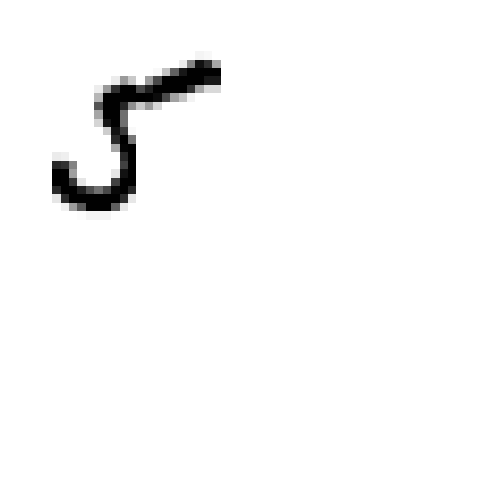

In [8]:
plt.imshow(get_sample(999, 0), cmap='gray_r', interpolation='none')
ax = plt.gca()
plt.axis('off')

(-0.5, 55.5, 55.5, -0.5)

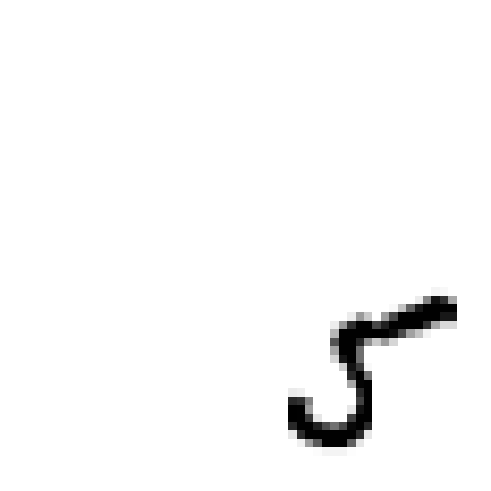

In [9]:
plt.imshow(get_sample(999, 1), cmap='gray_r', interpolation='none')
ax = plt.gca()
plt.axis('off')

(-0.5, 55.5, 55.5, -0.5)

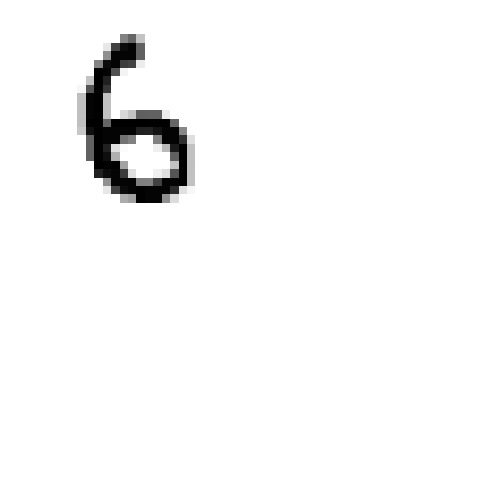

In [10]:
plt.imshow(get_sample(1999, 0), cmap='gray_r', interpolation='none')
ax = plt.gca()
plt.axis('off')

(-0.5, 55.5, 55.5, -0.5)

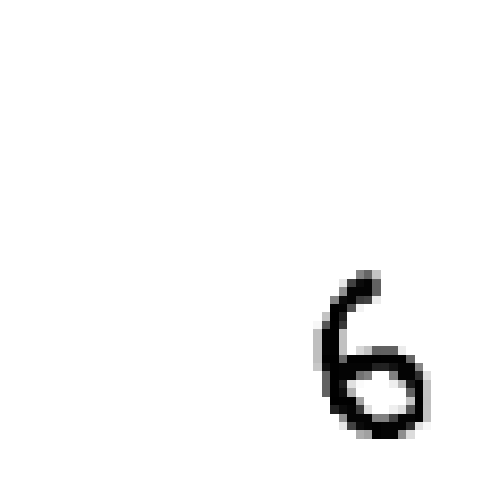

In [11]:
plt.imshow(get_sample(1999, 1), cmap='gray_r', interpolation='none')
ax = plt.gca()
plt.axis('off')

In [12]:
loc_1_test_data = []
loc_2_test_data = []
for i in range(2000):
    loc_1_test_data.append(get_sample(i, 0))
    loc_2_test_data.append(get_sample(i, 1))
loc_1_test_data = torch.cat(loc_1_test_data).view(len(loc_1_test_data), -1)
loc_2_test_data = torch.cat(loc_2_test_data).view(len(loc_2_test_data), -1)

In [13]:
digit_1_test_data = []
digit_2_test_data = []
for i in range(1000):
    digit_1_test_data.append(get_sample(i, 0))
    digit_1_test_data.append(get_sample(i, 1))
    digit_2_test_data.append(get_sample(i + 1000, 0))
    digit_2_test_data.append(get_sample(i + 1000, 1))
digit_1_test_data = torch.cat(digit_1_test_data).view(len(digit_1_test_data), -1)
digit_2_test_data = torch.cat(digit_2_test_data).view(len(digit_2_test_data), -1)

In [14]:
def get_init_batch(batch_size):
    idxs = torch.randperm(raw_data.shape[0])[:batch_size]
    raw_batch = raw_data[idxs]
    digit_labels = raw_labels[idxs]
    loc_labels = torch.randint_like(digit_labels, 2)
    
    b, c, w, h = raw_batch.shape
    out_batch = torch.zeros_like(raw_batch).repeat(1, 1, 2, 2)
    for i in range(b):
        position = loc_labels[i]
        out_batch[i, 0, w*position:w*(position+1), h*position:h*(position+1)] = raw_batch[i]
    
    return out_batch.view(b, -1), digit_labels, loc_labels

In [15]:
def location_sequence(in_batch, loc_labels, noise_probability=0):
    idxs = torch.randperm(raw_data.shape[0])[:in_batch.shape[0]]
    raw_batch = raw_data[idxs]
    digit_labels = raw_labels[idxs]
    
    b, c, w, h = raw_batch.shape
    out_batch = torch.zeros_like(raw_batch).repeat(1, 1, 2, 2)
    for i in range(b):
        position = loc_labels[i]
        out_batch[i, 0, w*position:w*(position+1), h*position:h*(position+1)] = raw_batch[i]
        
    return out_batch.view(b, -1), loc_labels
    

def digit_sequence(in_batch, digit_labels, noise_probability=0):
    
    loc_labels = torch.randint_like(digit_labels, 2)
    
    total_dig_1 = (raw_labels==0).sum()
    num_dig_1 = (digit_labels==0).sum()
    raw_batch_dig_1 = raw_data[raw_labels==0][torch.randperm(total_dig_1)][:num_dig_1]
    
    total_dig_2 = (raw_labels==1).sum()
    num_dig_2 = (digit_labels==1).sum()
    raw_batch_dig_2 = raw_data[raw_labels==1][torch.randperm(total_dig_2)][:num_dig_2]
    
    _, c, w, h = raw_data.shape
    b = in_batch.shape[0]
    raw_batch = torch.zeros(b, c, w, h)
    raw_batch[digit_labels==0] = raw_batch_dig_1
    raw_batch[digit_labels==1] = raw_batch_dig_2
    
    out_batch = torch.zeros_like(raw_batch).repeat(1, 1, 2, 2)
    for i in range(b):
        position = loc_labels[i]
        out_batch[i, 0, w*position:w*(position+1), h*position:h*(position+1)] = raw_batch[i]
        
    return out_batch.view(b, -1), digit_labels

In [16]:
data_center = get_init_batch(2000)[0].mean(dim=0)

### Performance measures

In [17]:
def location_sensitivity(net=None, decomp_model=None):
    if decomp_model is not None:
        out_loc_1 = torch.tensor(decomp_model.transform(loc_1_test_data))
        out_loc_2 = torch.tensor(decomp_model.transform(loc_2_test_data))
        
    elif net is not None:
        out_loc_1 = net(loc_1_test_data)
        out_loc_2 = net(loc_2_test_data)
    
    loc_sensitivity = torch.abs(out_loc_1.mean() - out_loc_2.mean()) /(torch.max(out_loc_1.max(), out_loc_2.max()) - torch.min(out_loc_1.min(), out_loc_2.min()))
    return loc_sensitivity.detach()


def digit_sensitivity(net=None, decomp_model=None):
    if decomp_model is not None:
        out_digit_1 = torch.tensor(decomp_model.transform(digit_1_test_data))
        out_digit_2 = torch.tensor(decomp_model.transform(digit_2_test_data))
        
    elif net is not None:
        out_digit_1 = net(digit_1_test_data)
        out_digit_2 = net(digit_2_test_data)
        
    digit_sensitivity = torch.abs(out_digit_1.mean() - out_digit_2.mean()) /(torch.max(out_digit_1.max(), out_digit_2.max()) - torch.min(out_digit_1.min(), out_digit_2.min()))
    return digit_sensitivity.detach()

# Learning sims

In [18]:
def hebbian_loss(a):
    a_center = a.mean(dim=0).detach()
    variance = ((a - a_center) ** 2).sum(dim=0) / (a.shape[0] - 1) + 1e-8
    loss = (-torch.log(variance)).mean()

    return loss

In [19]:
def set_param_specific_optim_params(named_params, skip_list=None):
    if skip_list is None:
        skip_list = ['bias']
    params = []
    params_no_weight_decay = []

    for name, param in named_params:
        if not param.requires_grad:
            continue
        elif any(layer_name in name for layer_name in skip_list):
            params_no_weight_decay.append(param)
        else:
            params.append(param)
    return [{'params': params},
            {'params': params_no_weight_decay, 'weight_decay': 0.}]

In [20]:
batch_size = 200

num_steps = 1000
num_runs = 10

learning_rate = 1e-2
weight_decay= 1.5e-1

In [21]:
def trainer(seq, num_steps, batch_size, pred_learning=False, hebb_learning=True, ojas_rule=False, lr=1e-2, weight_decay=1.5e-1):
    
    net = nn.Linear(nb_inputs, 1, bias=False)
    
    batch, digit_labels, loc_labels = get_init_batch(batch_size)
    if ojas_rule:
        batch -= data_center
    activities = torch.zeros(num_steps)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)

    y_past = net(batch)
    for p in tqdm.trange(num_steps):
        if seq == 'Dig. seq.':
            new_batch, new_loc_labels = digit_sequence(batch, loc_labels)
        elif seq == 'Loc. seq.':
            new_batch, new_loc_labels = location_sequence(batch, loc_labels)
        
        if ojas_rule:
            new_batch -= data_center
            
        y = net(new_batch)
        loss = 0.

        if ojas_rule:
            net.weight.data += (lr*y*(new_batch-y*net.weight.data)).mean(dim=0)
        else:
            if hebb_learning:
                loss += hebbian_loss(y)
            
            if pred_learning:
                loss += pred_loss(y, y_past.detach())
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        activities[p] = torch.abs(y.mean()).detach()
        batch, loc_labels = new_batch.clone(), new_loc_labels.clone()
        y_past = y.clone()
    
    return net, activities

In [22]:
loc_sensitivities = {}
digit_sensitivities = {}
activity_norms = {}
sample_weights = {}

In [23]:
algos = ['LPL', 'Pred. off', 'Oja']
sequences = ['Dig. seq.', 'Loc. seq.']

for algo in algos:
    loc_sensitivities[algo] = {}
    digit_sensitivities[algo] = {}
    activity_norms[algo] = {}
    sample_weights[algo] = {}
    for seq in sequences:
        loc_sensitivities[algo][seq] = []
        digit_sensitivities[algo][seq] = []
        activity_norms[algo][seq] = []

## Oja's rule

### Location sequence

In [24]:
algo = 'Oja'
seq = 'Loc. seq.'
weights = []

nb_inputs = get_init_batch(batch_size)[0].shape[-1]

for i in range(num_runs):
    
    net, activities = trainer(seq, num_steps, batch_size, ojas_rule=True, lr=learning_rate, weight_decay=0.)
    
    weights.append(net.weight.data[0].clone().reshape(56, 56))
    loc_sensitivities[algo][seq].append(location_sensitivity(net=net))
    digit_sensitivities[algo][seq].append(digit_sensitivity(net=net))

sample_weights[algo][seq] = weights[-1]

100%|██████████| 1000/1000 [00:06<00:00, 153.29it/s]


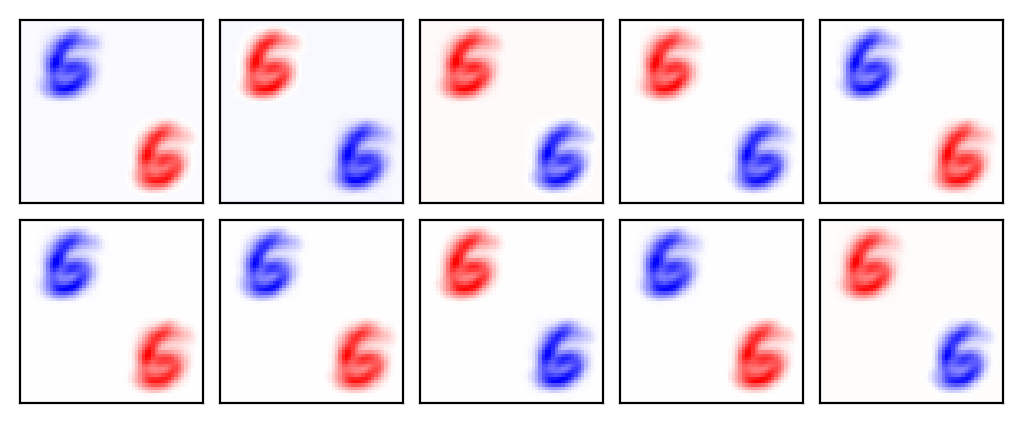

In [25]:
fig = plt.figure(figsize=(5,2), dpi=200)
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(weights[i*5 + j], cmap='bwr', interpolation='none')
        plt.xticks([], [])
        plt.yticks([], [])

### Digit sequence

In [26]:
algo = 'Oja'
seq = 'Dig. seq.'
weights = []

nb_inputs = get_init_batch(batch_size)[0].shape[-1]

for i in range(num_runs):

    net, activities = trainer(seq, num_steps, batch_size, ojas_rule=True, lr=learning_rate, weight_decay=0.)
    
    weights.append(net.weight.data[0].clone().reshape(56, 56))
    loc_sensitivities[algo][seq].append(location_sensitivity(net=net))
    digit_sensitivities[algo][seq].append(digit_sensitivity(net=net))

sample_weights[algo][seq] = weights[-1]

100%|██████████| 1000/1000 [00:06<00:00, 147.76it/s]


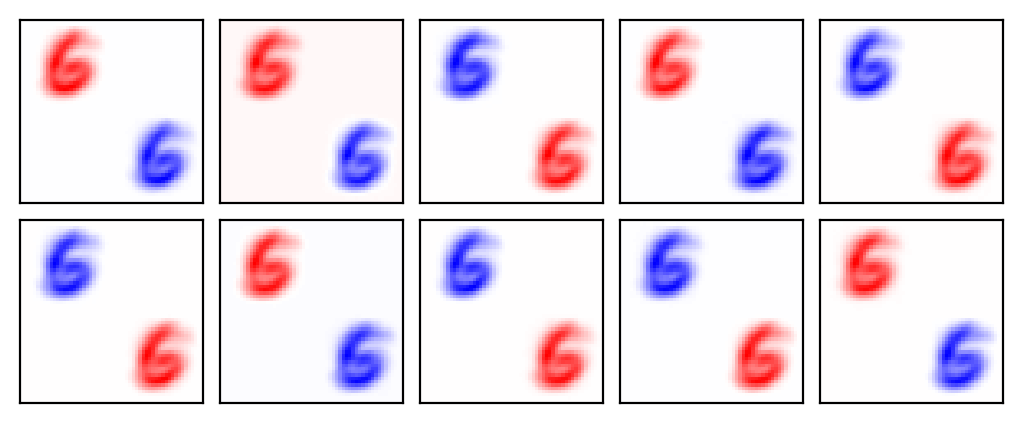

In [27]:
fig = plt.figure(figsize=(5,2), dpi=200)
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(weights[i*5 + j], cmap='bwr', interpolation='none')
        plt.xticks([], [])
        plt.yticks([], [])

## Pred off

### Location sequence

In [28]:
algo = 'Pred. off'
seq = 'Loc. seq.'
weights = []

nb_inputs = get_init_batch(batch_size)[0].shape[-1]

for i in range(num_runs):
    
    net, activities = trainer(seq, num_steps, batch_size, hebb_learning=True, pred_learning=False, lr=learning_rate, weight_decay=weight_decay)
    
    weights.append(net.weight.data[0].clone().reshape(56, 56))
    loc_sensitivities[algo][seq].append(location_sensitivity(net=net))
    digit_sensitivities[algo][seq].append(digit_sensitivity(net=net))

sample_weights[algo][seq] = weights[-1]

100%|██████████| 1000/1000 [00:05<00:00, 171.53it/s]


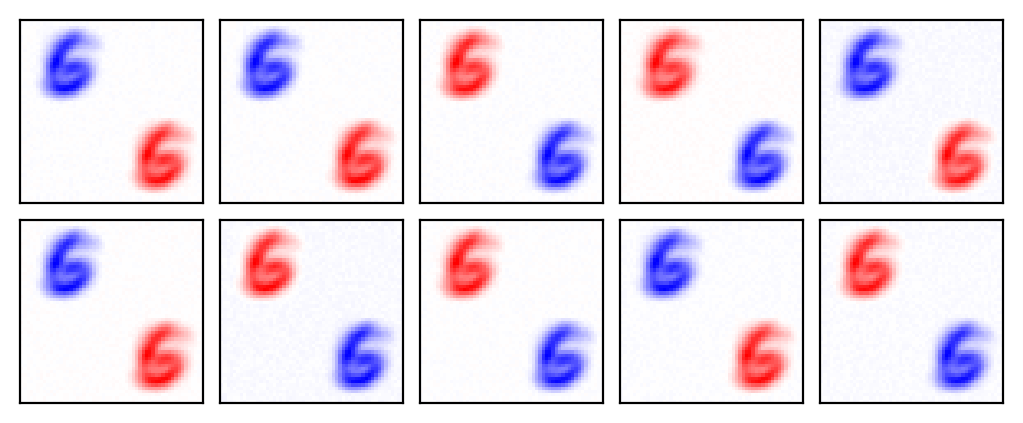

In [29]:
fig = plt.figure(figsize=(5,2), dpi=200)
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(weights[i*5 + j], cmap='bwr', interpolation='none')
        plt.xticks([], [])
        plt.yticks([], [])

### Digit sequence

In [30]:
algo = 'Pred. off'
seq = 'Dig. seq.'
weights = []

nb_inputs = get_init_batch(batch_size)[0].shape[-1]

for i in range(num_runs):
    
    net, activities = trainer(seq, num_steps, batch_size, hebb_learning=True, pred_learning=False, lr=learning_rate, weight_decay=weight_decay)
    
    weights.append(net.weight.data[0].clone().reshape(56, 56))
    loc_sensitivities[algo][seq].append(location_sensitivity(net=net))
    digit_sensitivities[algo][seq].append(digit_sensitivity(net=net))

sample_weights[algo][seq] = weights[-1]

100%|██████████| 1000/1000 [00:06<00:00, 149.38it/s]


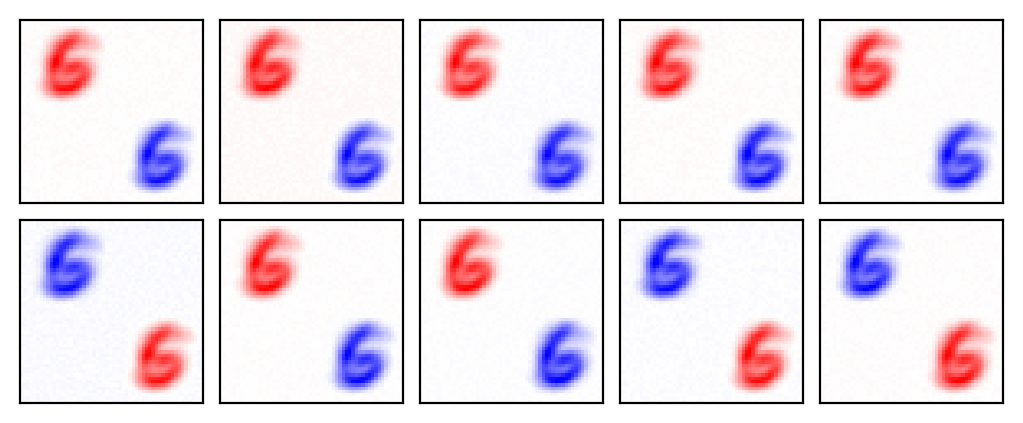

In [31]:
fig = plt.figure(figsize=(5,2), dpi=200)
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(weights[i*5 + j], cmap='bwr', interpolation='none')
        plt.xticks([], [])
        plt.yticks([], [])

## LPL

### Location sequence

In [32]:
algo = 'LPL'
seq = 'Loc. seq.'
weights = []

nb_inputs = get_init_batch(batch_size)[0].shape[-1]

pred_loss = nn.MSELoss()

for i in range(num_runs):

    net, activities = trainer(seq, num_steps, batch_size, hebb_learning=True, pred_learning=True, lr=learning_rate, weight_decay=weight_decay)
    
    weights.append(net.weight.data[0].clone().reshape(56, 56))
    loc_sensitivities[algo][seq].append(location_sensitivity(net=net))
    digit_sensitivities[algo][seq].append(digit_sensitivity(net=net))

sample_weights[algo][seq] = weights[-1]

100%|██████████| 1000/1000 [00:05<00:00, 168.31it/s]


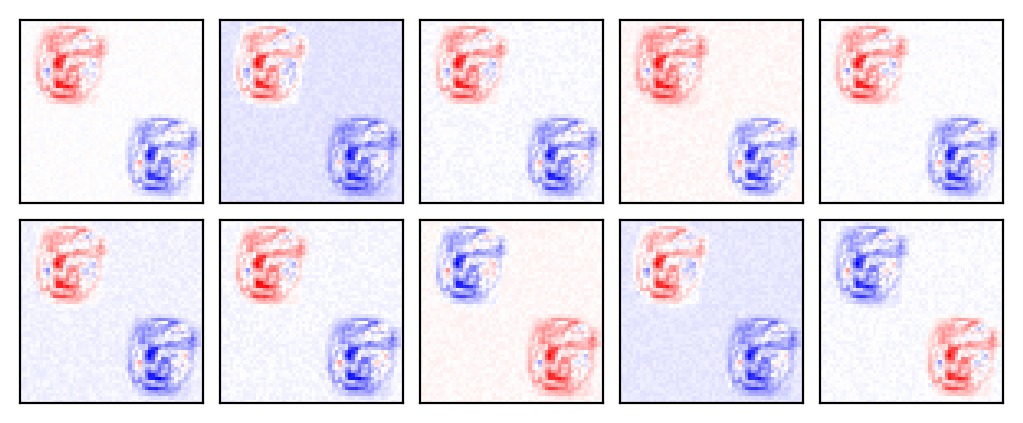

In [33]:
fig = plt.figure(figsize=(5,2), dpi=200)
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(weights[i*5 + j], cmap='bwr', interpolation='none')
        plt.xticks([], [])
        plt.yticks([], [])

### Digit sequence

In [34]:
algo = 'LPL'
seq = 'Dig. seq.'
activity_norms[algo][seq] = []
loc_sensitivities[algo][seq] = []
digit_sensitivities[algo][seq] = []
weights = []

nb_inputs = get_init_batch(batch_size)[0].shape[-1]

pred_loss = nn.MSELoss()

for i in range(num_runs):

    net, activities = trainer(seq, num_steps, batch_size, hebb_learning=True, pred_learning=True, lr=learning_rate, weight_decay=weight_decay)
    
    weights.append(net.weight.data[0].clone().reshape(56, 56))
    loc_sensitivities[algo][seq].append(location_sensitivity(net=net))
    digit_sensitivities[algo][seq].append(digit_sensitivity(net=net))

sample_weights[algo][seq] = weights[-1]

100%|██████████| 1000/1000 [00:06<00:00, 144.76it/s]


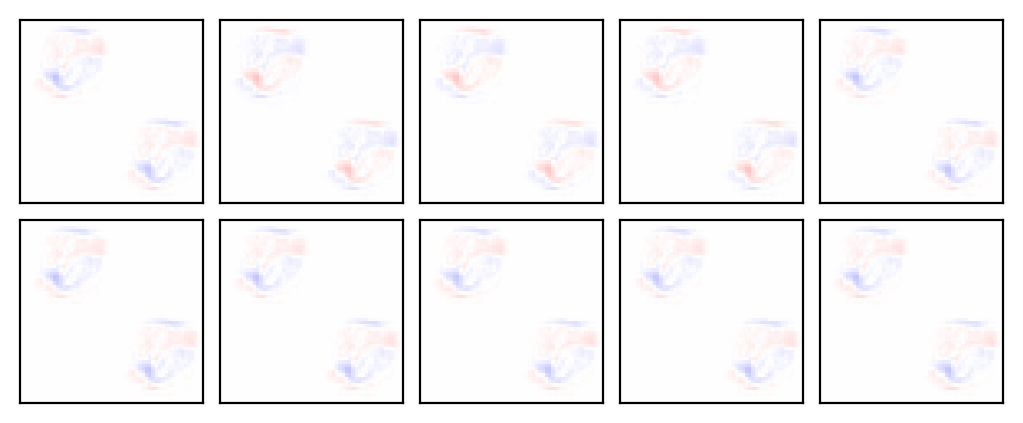

In [35]:
fig = plt.figure(figsize=(5,2), dpi=200)
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(weights[i*5 + j], cmap='bwr', interpolation='none', vmin=-1, vmax=1)
        plt.xticks([], [])
        plt.yticks([], [])

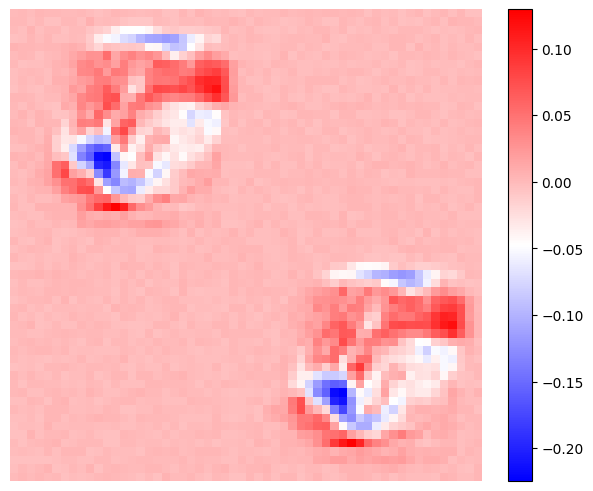

In [36]:
plt.imshow(weights[i*5 + j], cmap='bwr', interpolation='none')
plt.axis('off')
plt.colorbar()

## Random weights

In [37]:
activity_norms_init = []
loc_sensitivities_init = []
digit_sensitivities_init = []

weights = []

nb_inputs = get_init_batch(batch_size)[0].shape[-1]

matching_loss = nn.MSELoss()

for i in range(num_runs):
    
    print('Run ' + str(i))
    net = nn.Linear(nb_inputs, 1, bias=False)
    
    batch, digit_labels, loc_labels = get_init_batch(batch_size)
    y = net(batch)
    activity_norms_init.append(torch.abs(y.mean()).detach())
    
    weights.append(net.weight.data[0].clone().reshape(56, 56))
    loc_sensitivities_init.append(location_sensitivity(net=net))
    digit_sensitivities_init.append(digit_sensitivity(net=net))

weights_init = weights[-1]

Run 0
Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9


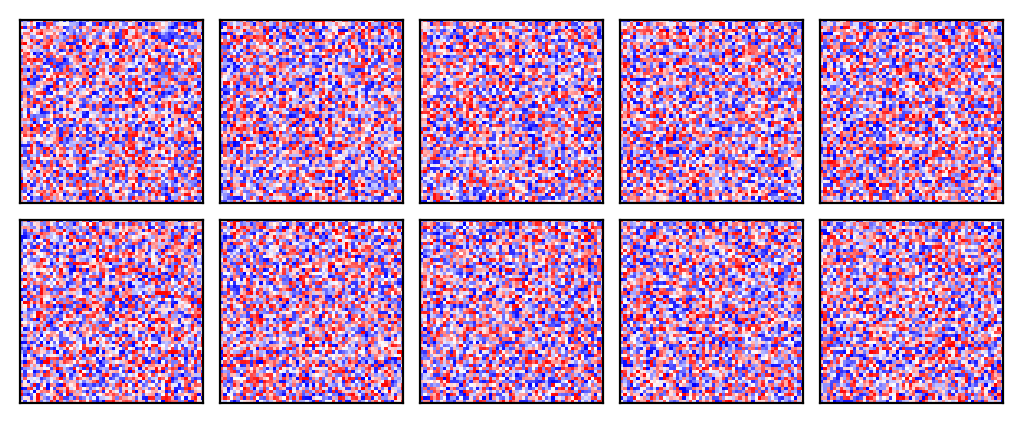

In [38]:
fig = plt.figure(figsize=(5,2), dpi=200)
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(weights[i*5 + j], cmap='bwr', interpolation='none')
        plt.xticks([], [])
        plt.yticks([], [])

## Results summary

In [39]:
sequences.reverse()

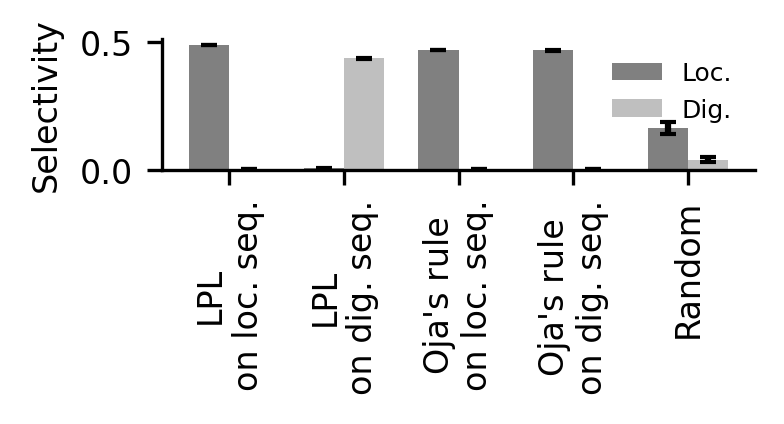

In [40]:
fig = plt.figure(figsize=(2.5, 1.3), dpi=300)

# Location sequence
y_loc = []
y_loc_err = []
for algo in algos[::2]:
    for seq in sequences:
        y_loc.append(np.mean(loc_sensitivities[algo][seq]))
        y_loc_err.append(np.std(loc_sensitivities[algo][seq])/np.sqrt(num_runs))
y_loc.append(np.mean(loc_sensitivities_init))
y_loc_err.append(np.std(loc_sensitivities_init)/np.sqrt(num_runs))


y_dig = []
y_dig_err = []
for algo in algos[::2]:
    for seq in sequences:
        y_dig.append(np.mean(digit_sensitivities[algo][seq]))
        y_dig_err.append(np.std(digit_sensitivities[algo][seq])/np.sqrt(num_runs))
y_dig.append(np.mean(digit_sensitivities_init))
y_dig_err.append(np.std(digit_sensitivities_init)/np.sqrt(num_runs))

barWidth = 0.35

r1 = np.arange(2*len(algos[::2]) + 1)
r2 = [x + barWidth for x in r1]

plt.bar(r1, y_loc, color ='gray', width = barWidth, yerr = y_loc_err, capsize=2, label='Loc.')
plt.bar(r2, y_dig, color ='gray', alpha=0.5, width = barWidth, yerr = y_dig_err, capsize=2, label='Dig.')
plt.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.tick_params(axis = 'x', which = 'major', rotation=90)
xlabels = ['LPL\non loc. seq.', 'LPL\non dig. seq.', 'Oja\'s rule\non loc. seq.', 'Oja\'s rule\non dig. seq.']
plt.xticks([r + 0.5*barWidth for r in range(len(r1))], xlabels+['Random'])
plt.ylabel('Selectivity', fontsize=8)
lgd = plt.legend(frameon=False, fontsize=6)
# lgd = plt.legend(frameon=False, fontsize=6, loc=(0.9,0.4))
sns.despine()

# plt.savefig(os.path.join(outputdir,'MNIST_selectivity.pdf'), bbox_inches='tight', backend='pgf')

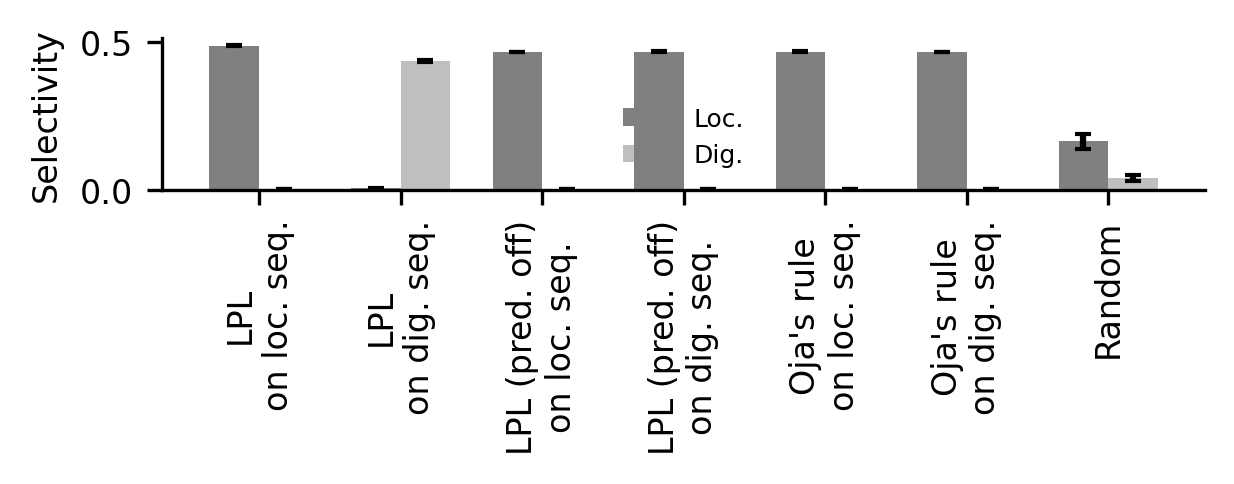

In [41]:
fig = plt.figure(figsize=(4, 1.5), dpi=300)

# Location sequence
y_loc = []
y_loc_err = []
for algo in algos:
    for seq in sequences:
        y_loc.append(np.mean(loc_sensitivities[algo][seq]))
        y_loc_err.append(np.std(loc_sensitivities[algo][seq])/np.sqrt(num_runs))
y_loc.append(np.mean(loc_sensitivities_init))
y_loc_err.append(np.std(loc_sensitivities_init)/np.sqrt(num_runs))


y_dig = []
y_dig_err = []
for algo in algos:
    for seq in sequences:
        y_dig.append(np.mean(digit_sensitivities[algo][seq]))
        y_dig_err.append(np.std(digit_sensitivities[algo][seq])/np.sqrt(num_runs))
y_dig.append(np.mean(digit_sensitivities_init))
y_dig_err.append(np.std(digit_sensitivities_init)/np.sqrt(num_runs))

barWidth = 0.35

r1 = np.arange(2*len(algos) + 1)
r2 = [x + barWidth for x in r1]

plt.bar(r1, y_loc, color ='gray', width = barWidth, yerr = y_loc_err, capsize=2, label='Loc.')
plt.bar(r2, y_dig, color ='gray', alpha=0.5, width = barWidth, yerr = y_dig_err, capsize=2, label='Dig.')
plt.tick_params(axis = 'both', which = 'major', labelsize=8)
plt.tick_params(axis = 'x', which = 'major', rotation=90)
xlabels = ['LPL\non loc. seq.', 'LPL\non dig. seq.', 'LPL (pred. off)\non loc. seq.', 'LPL (pred. off)\non dig. seq.', 'Oja\'s rule\non loc. seq.', 'Oja\'s rule\non dig. seq.']
plt.xticks([r + 0.5*barWidth for r in range(len(r1))], xlabels+['Random'])
plt.ylabel('Selectivity', fontsize=8)
lgd = plt.legend(frameon=False, fontsize=6)
# lgd = plt.legend(frameon=False, fontsize=6, loc=(0.9,0.4))
sns.despine()

# plt.savefig(os.path.join(outputdir,'MNIST_selectivity_full.pdf'), bbox_inches='tight', backend='pgf')

In [42]:
algos

['LPL', 'Pred. off', 'Oja']

([], [])

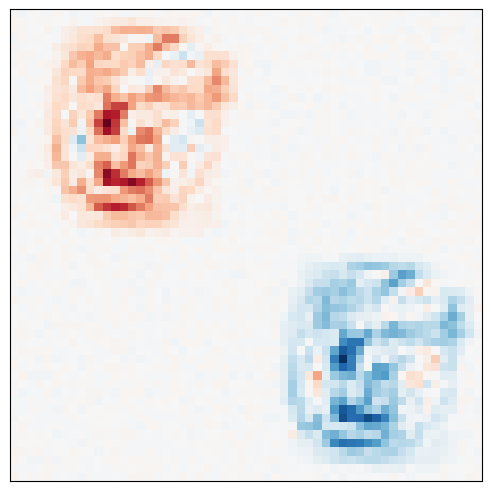

In [43]:
weights = sample_weights['LPL']['Loc. seq.']
divnorm=colors.TwoSlopeNorm(vmin=weights.min(), vcenter=0., vmax=weights.max())
plt.imshow(weights, cmap='RdBu', interpolation='none', norm=divnorm)
plt.xticks([], [])
plt.yticks([], [])

([], [])

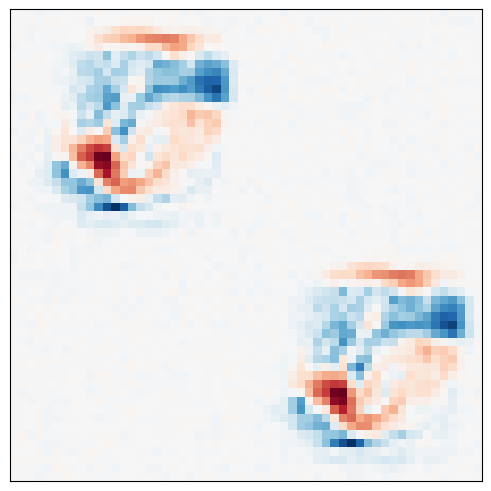

In [44]:
weights = sample_weights['LPL']['Dig. seq.']
divnorm=colors.TwoSlopeNorm(vmin=weights.min(), vcenter=0., vmax=weights.max())
plt.imshow(weights, cmap='RdBu', interpolation='none', norm=divnorm)
plt.xticks([], [])
plt.yticks([], [])

([], [])

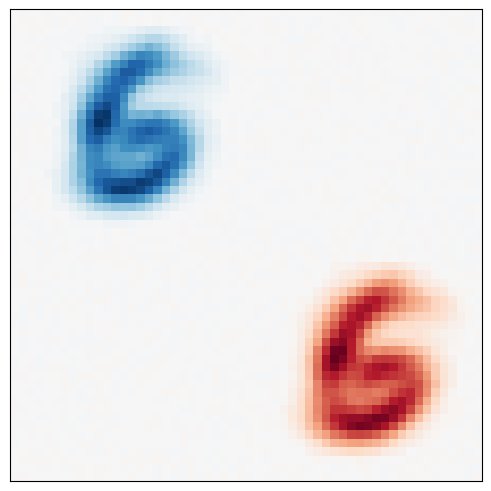

In [45]:
weights = sample_weights['Pred. off']['Loc. seq.']
divnorm=colors.TwoSlopeNorm(vmin=weights.min(), vcenter=0., vmax=weights.max())
plt.imshow(weights, cmap='RdBu', interpolation='none', norm=divnorm)
plt.xticks([], [])
plt.yticks([], [])

([], [])

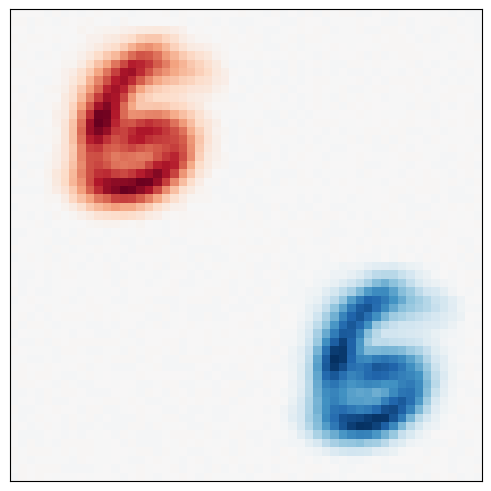

In [46]:
weights = sample_weights['Pred. off']['Dig. seq.']
divnorm=colors.TwoSlopeNorm(vmin=weights.min(), vcenter=0., vmax=weights.max())
plt.imshow(weights, cmap='RdBu', interpolation='none', norm=divnorm)
plt.xticks([], [])
plt.yticks([], [])

([], [])

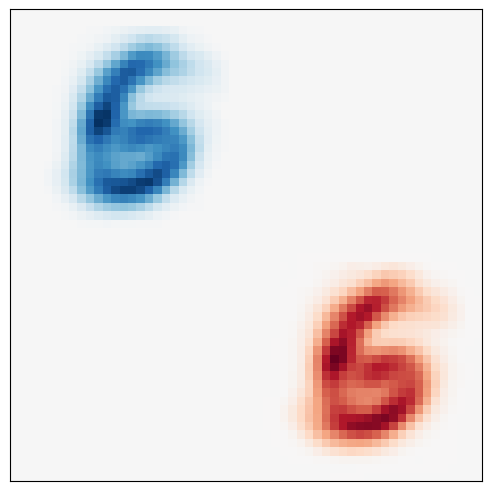

In [47]:
weights = sample_weights['Oja']['Loc. seq.']
divnorm=colors.TwoSlopeNorm(vmin=weights.min(), vcenter=0., vmax=weights.max())
plt.imshow(weights, cmap='RdBu', interpolation='none', norm=divnorm)
plt.xticks([], [])
plt.yticks([], [])

([], [])

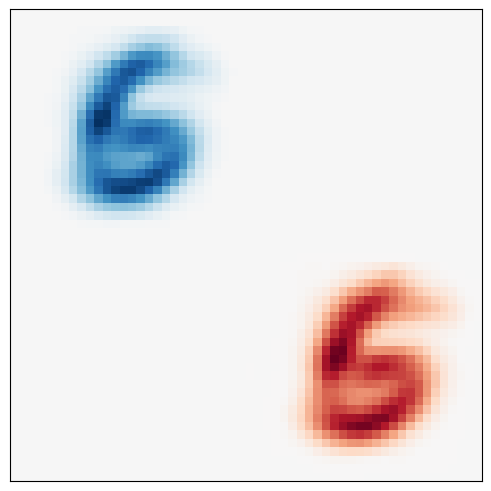

In [48]:
weights = sample_weights['Oja']['Dig. seq.']
divnorm=colors.TwoSlopeNorm(vmin=weights.min(), vcenter=0., vmax=weights.max())
plt.imshow(weights, cmap='RdBu', interpolation='none', norm=divnorm)
plt.xticks([], [])
plt.yticks([], [])

([], [])

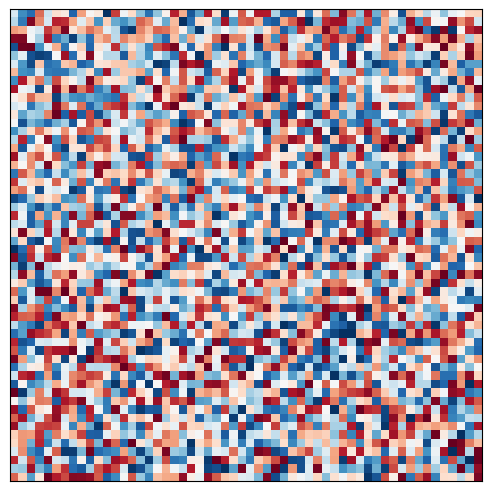

In [49]:
weights = weights_init
divnorm=colors.TwoSlopeNorm(vmin=weights.min(), vcenter=0., vmax=weights.max())
plt.imshow(weights, cmap='RdBu', interpolation='none', norm=divnorm)
plt.xticks([], [])
plt.yticks([], [])